In [1]:
# Import packages
import pandas as pd
from pydantic import BaseModel, Field, EmailStr, field_validator
from pydantic_ai import Agent
from typing import Literal, List, Optional # List[str]
from datetime import datetime, date
import json
from openai import OpenAI
import anthropic
import instructor

from dotenv import load_dotenv
load_dotenv(".env", override=True)

import nest_asyncio

nest_asyncio.apply()

In [2]:
# Define your UserInput model

class UserInput(BaseModel):
    name: str = Field(..., description="User's name")
    email: EmailStr = Field(..., description="User's email address")
    query: str = Field(..., description="User's query")
    order_id: Optional[str] = Field(None, description="Order ID if available (format: ABC-12345)")
    purchase_date: Optional[date] = None
    # Validate order_id format (e.g., ABC-12345)
    @field_validator("order_id") # decorator
    def validate_order_id(cls, order_id):
        import re
        if order_id is None:
            return order_id

        pattern = r"^[A-Z]{3}-\d{5}$" 
        if not re.match(pattern, order_id):
            raise ValueError(
                "order_id must be in format ABC-12345 "
                "(3 uppercase letters, dash, 5 digits)"
            )
        return order_id
    

In [3]:
# Define a function to validate user input
def validate_user_input(user_json: str):
    """Validate user input from a JSON string and return a UserInput 
    instance if valid, otherwise None."""
    try:
        user_input = UserInput.model_validate_json(user_json)
        print("user input validated...")
        return user_input
    except Exception as e:
        print(f" Unexpected error: {e}")
        return None

In [5]:
list({1,2,3})

[1, 2, 3]

In [6]:
list(str)

TypeError: 'type' object is not iterable

In [4]:
# Define your CustomerQuery model
class CustomerQuery(UserInput):
    priority: str = Field(..., description="Priority level: low, medium, high")
    category: Literal['refund_request', 'information_request', 'other'
    ] = Field(..., description="Query category")
    is_complaint: bool = Field(..., description="Whether this is a complaint")
    tags: List[str] = Field(..., description="Relevant keyword tags")

In [7]:
# Define a function to call an LLM using Pydantic AI to create an instance of CustomerQuery
def create_customer_query(valid_user_json: str) -> CustomerQuery:
    
    customer_query_agent = Agent(
        model="google-gla:gemini-2.0-flash",
        output_type=CustomerQuery,
    )
    response = customer_query_agent.run_sync(valid_user_json)
    print("CustomerQuery generated...")
    return response.output

In [9]:
# Create a fake FAQ database as a list of entries with keywords
faq_db = [
    {
        "question": "How can I reset my password?",
        "answer": "To reset your password, click 'Forgot Password' on the sign-in page and follow the instructions sent to your email.",
        "keywords": ["password", "reset", "account"]
    },
    {
        "question": "How long does shipping take?",
        "answer": "Standard shipping takes 3-5 business days. You can track your order in your account dashboard.",
        "keywords": ["shipping", "delivery", "order", "tracking"]
    },
    {
        "question": "How can I return an item?",
        "answer": "You can return any item within 30 days of purchase. Visit our returns page to start the process.",
        "keywords": ["return", "refund", "exchange"]
    },
    {
        "question": "How can I delete my account?",
        "answer": "To delete your account, go to your account settings tab and select 'delete account'.",
        "keywords": ["delete", "account", "remove"]
    }
]

# Create a fake order database
order_db = {
    
    "ABC-12345": {
        "status": "shipped", "estimated_delivery": "2025-12-05",
        "purchase_date": "2025-12-01", "email": "waqas@gmail.com"
    },
    "XYZ-23456": {
        "status": "processing", "estimated_delivery": "2025-12-15",
        "purchase_date": "2025-12-10", "email": "salman@example.com"
    },
    "QWE-34567": {
        "status": "delivered", "estimated_delivery": "2025-12-20",
        "purchase_date": "2025-12-18", "email": "ali@example.com"
    }
    
}

In [11]:
# Define FAQ Lookup tool input as a Pydantic model
class FAQLookupArgs(BaseModel):
    query: str = Field(..., description="User's query") 
    tags: List[str] = Field(
        ..., description="Relevant keyword tags from the customer query"
    )

In [12]:
# Define your FAQ lookup tool

def lookup_faq_answer(args: FAQLookupArgs) -> str: # query:str, tags: ["laptop", "password"]
    """Look up an FAQ answer by matching tags and words in query 
    to FAQ entry keywords."""
    query_words = set(word.lower() for word in args.query.split())
    tag_set = set(tag.lower() for tag in args.tags)
    
    best_match = None # dictionary
    best_score = 0
    for faq in faq_db: # faq = dict
        keywords = set(k.lower() for k in faq["keywords"])
        score = len(keywords & tag_set) + len(keywords & query_words)
        if score > best_score:
            best_score = score
            best_match = faq
    if best_match and best_score > 0:
        return best_match["answer"]
    return "Sorry, I couldn't find an FAQ answer for your question."

In [14]:
# Define Check Order Status tool input as a Pydantic model
class CheckOrderStatusArgs(BaseModel): # pydantic base model
    order_id: str = Field(
        ..., description="Customer's order ID (format: ABC-12345)"
    )
    email: EmailStr = Field(..., description="Customer's email address")

    @field_validator("order_id")
    def validate_order_id(cls, order_id):
        import re
        pattern = r"^[A-Z]{3}-\d{5}$"
        if not re.match(pattern, order_id):
            raise ValueError(
                "order_id must be in format ABC-12345 "
                "(3 uppercase letters, dash, 5 digits)"
            )
        return order_id

In [15]:
# Define your check order status tool
def check_order_status(args: CheckOrderStatusArgs) -> dict: # order_id:str, email: w@g.c
    """Simulate checking the status of a customer's order by 
    order_id and email."""
    order = order_db.get(args.order_id, None) #  return dict  {"status": "shipped", "estimated_delivery": "2025-12-05""purchase_date": "2025-12-01", "email": "waqas@gmail.com"

    if not order:
        return {
            "order_id": args.order_id,
            "status": "not found",
            "estimated_delivery": None,
            "note": "order_id not found"
        }
        
    elif args.email.lower() != order.get("email", "").lower():
        return {
            "order_id": args.order_id,
            "status": order["status"],
            "estimated_delivery": order["estimated_delivery"],
            "note": "order_id found but email mismatch"
        }
        
    return {
        "order_id": args.order_id,
        "status": order["status"],
        "estimated_delivery": order["estimated_delivery"],
        "note": "order_id and email match"
    } 

In [16]:
CheckOrderStatusArgs.model_json_schema()

{'properties': {'order_id': {'description': "Customer's order ID (format: ABC-12345)",
   'title': 'Order Id',
   'type': 'string'},
  'email': {'description': "Customer's email address",
   'format': 'email',
   'title': 'Email',
   'type': 'string'}},
 'required': ['order_id', 'email'],
 'title': 'CheckOrderStatusArgs',
 'type': 'object'}

In [17]:
tool_definitions = [
    {
        "type": "function",
        "function": {
            "name": "lookup_faq_answer",
            "description": "Look up an FAQ answer by matching tags to FAQ entry keywords.",
            "parameters": FAQLookupArgs.model_json_schema() # query:str, tags: list[str]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "check_order_status",
            "description": "Check the status of a customer's order.",
            "parameters": CheckOrderStatusArgs.model_json_schema()
        }
    }
]

In [18]:
#Define your final output Pydantic models
class OrderDetails(BaseModel):
    status: str
    estimated_delivery: str
    note: str

class SupportTicket(CustomerQuery):
    recommended_next_action: Literal[
        'escalate_to_agent', 'send_faq_response', 
        'send_order_status', 'no_action_needed'
    ] = Field(
        ..., description="LLM's recommended next action for support"
    )
    order_details: Optional[OrderDetails] = Field(
        None, description="Order details if action is send_order_status"
    )
    faq_response: Optional[str] = Field(
        None, description="FAQ response if action is send_faq_response"
    )
    creation_date: datetime = Field(
        ..., description="Date and time the ticket was created"
    )

In [19]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()

In [20]:
# Define a function to call OpenAI with tools
def decide_next_action_with_tools(customer_query: CustomerQuery):
    
    support_ticket_schema = json.dumps(SupportTicket.model_json_schema(), indent=2)
    
    system_prompt = f"""
        You are a helpful customer support agent. Your job is to 
        determine what support action should be taken for the customer, 
        based on the customer query and the expected fields in the 
        SupportTicket schema below. If more information on a particular 
        order_id or FAQ response would be helpful in responding to the 
        user query and can be obtained by calling a tool, call the 
        appropriate tool to get that information. If an order_id is 
        present in the query, always look up the order status to get 
        more information on the order.

        Here is the JSON schema for the SupportTicket model you must 
        use as context for what information is expected:
        {support_ticket_schema}
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": str(customer_query.model_dump())}
    ]
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=tool_definitions,
        tool_choice="auto"
    )
    resp = response.choices[0].message
    tool_calls = getattr(resp, "tool_calls", None)
    return resp, tool_calls

In [21]:
# Define a function to get tool outputs

def get_tool_outputs(tool_calls): # list
    tool_outputs = [] #  list of dict
    if tool_calls: # list
        for tool_call in tool_calls:
            if tool_call.function.name == "lookup_faq_answer":
                print("Agent requested a call to the Lookup FAQ tool...")
                args = FAQLookupArgs.model_validate_json(
                    tool_call.function.arguments
                )
                result = lookup_faq_answer(args)
                tool_outputs.append({
                    "tool_call_id": tool_call.id, "output": result
                })
                print(f"Lookup FAQ tool returned {result}")
                
            elif tool_call.function.name == "check_order_status":
                print("Agent requested a call to Check Order Status tool...")
                args = CheckOrderStatusArgs.model_validate_json(
                    tool_call.function.arguments
                )
                result = check_order_status(args) # dictionary
                tool_outputs.append({
                    "tool_call_id": tool_call.id, "output": result
                })
                print(f"Check Order Status tool returned {result}")
    return tool_outputs # list dict

### Generate a structured support ticket using Anthropic

In [26]:
# Create the Anthropic client with Instructor
# anthropic_client = instructor.from_anthropic(anthropic.Anthropic())

# Define a function to call Anthropic to generate a support ticket
def generate_structured_support_ticket(customer_query: CustomerQuery, 
                                       resp, tool_outputs: list):
    
    tool_results_str = "\n".join([f"Tool: {out['tool_call_id']} Output: {json.dumps(out['output'])}" for out in tool_outputs]) if tool_outputs else "No tool calls were made."
    # Concatenate prompt parts into a single string for Anthropic
    prompt = f"""
        You are a support agent. Use all information below to 
        generate a support ticket as a validated Pydantic model.
        Customer query: {customer_query.model_dump_json(indent=2)}
        LLM message: {str(resp.content)}
        Tool results: {tool_results_str}
    """
    # Create the message with structured output
    response = client.responses.parse(
    model="gpt-4o",
    max_output_tokens=1024,
    input=[{"role": "user", "content": prompt}],
    text_format=SupportTicket)
    
    # response = anthropic_client.messages.create(
    #     model="claude-3-7-sonnet-latest",  
    #     max_tokens=1024,
    #     messages=[
    #         {
    #             "role": "user", 
    #             "content": prompt
    #         }
    #     ],
    #     response_model=SupportTicket
    # )
    
    support_ticket = response
    support_ticket.creation_date = datetime.now()
    return support_ticket

### Full workflow: validate, query, decide, tool, and generate ticket

In [27]:
# Define new user input data
user_json = '''
{
    "name": "Waqas",
    "email": "waqas@gmail.com",
    "query": "I'm really not happy with this product I bought",
    "order_id": "QWE-34567",
    "purchase_date": null
}
'''

In [28]:
# Run the entire pipeline
valid_user_json = validate_user_input(user_json).model_dump_json()

customer_query = create_customer_query(valid_user_json)

message, tool_calls = decide_next_action_with_tools(customer_query)

tool_outputs = get_tool_outputs(tool_calls)

support_ticket = generate_structured_support_ticket(customer_query, message, tool_outputs)

print(support_ticket.model_dump_json(indent=2))

user input validated...
CustomerQuery generated...
Agent requested a call to Check Order Status tool...
Check Order Status tool returned {'order_id': 'QWE-34567', 'status': 'delivered', 'estimated_delivery': '2025-12-20', 'note': 'order_id found but email mismatch'}
{
  "id": "resp_0043128ff306917600690706fab0f481a19aa06a67fe6e9431",
  "created_at": 1762068218.0,
  "error": null,
  "incomplete_details": null,
  "instructions": null,
  "metadata": {},
  "model": "gpt-4o-2024-08-06",
  "object": "response",
  "output": [
    {
      "id": "msg_0043128ff306917600690706fb8e8081a1b6f35e913bd46352",
      "content": [
        {
          "annotations": [],
          "text": "{\"name\":\"Waqas\",\"email\":\"waqas@gmail.com\",\"query\":\"I'm really not happy with this product I bought\",\"order_id\":\"QWE-34567\",\"purchase_date\":null,\"priority\":\"high\",\"category\":\"other\",\"is_complaint\":true,\"tags\":[\"product issue\"],\"recommended_next_action\":\"escalate_to_agent\",\"order_detail

In [31]:
# Reflection

In [29]:
df = pd.read_csv("coffee_sales.csv")

In [30]:
df.head()

,date,time,cash_type,card,price,coffee_name
0,2024-03-01,06:14,card,ANON-0000-0000-0001,3.87,Latte
1,2024-03-01,11:10,card,ANON-0000-0000-0002,3.87,Hot Chocolate
2,2024-03-01,11:19,card,ANON-0000-0000-0002,3.87,Hot Chocolate
3,2024-03-01,11:37,card,ANON-0000-0000-0003,2.89,Americano
4,2024-03-01,12:56,card,ANON-0000-0000-0004,3.87,Latte


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   time         3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   price        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB


In [33]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["quarter"] = df["date"].dt.quarter
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [34]:
df

,date,time,cash_type,card,price,coffee_name,quarter,month,year
0,2024-03-01,06:14,card,ANON-0000-0000-0001,3.870,Latte,1,3,2024
1,2024-03-01,11:10,card,ANON-0000-0000-0002,3.870,Hot Chocolate,1,3,2024
2,2024-03-01,11:19,card,ANON-0000-0000-0002,3.870,Hot Chocolate,1,3,2024
3,2024-03-01,11:37,card,ANON-0000-0000-0003,2.890,Americano,1,3,2024
4,2024-03-01,12:56,card,ANON-0000-0000-0004,3.870,Latte,1,3,2024
...,...,...,...,...,...,...,...,...,...
3631,2025-03-23,11:17,card,ANON-0000-0000-1158,3.576,Cappuccino,1,3,2025
3632,2025-03-23,13:07,card,ANON-0000-0000-1315,3.576,Cocoa,1,3,2025
3633,2025-03-23,13:51,card,ANON-0000-0000-1315,3.576,Cocoa,1,3,2025
3634,2025-03-23,15:09,card,ANON-0000-0000-1316,2.596,Americano,1,3,2025


In [36]:
instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv."

In [35]:
out_path_v1="ML_v1.png"

In [37]:
prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    
    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

In [38]:
print(prompt)


    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.


    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as 'ML_v1.png' with dpi=300.
    5. Do call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code 

In [39]:
model="gpt-4o-mini"

response = client.responses.create(
            model=model,
            input=prompt)

In [40]:
code_v1 = response.output_text

In [41]:
print(code_v1)

<execute_python>
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
# df = pd.read_csv('coffee_sales.csv')  # Uncomment this line if not loaded

# Filter for Q1 sales in 2024 and 2025
q1_sales = df[(df['quarter'] == 1) & (df['year'].isin([2024, 2025]))]

# Group by year and coffee name, summing the price
sales_summary = q1_sales.groupby(['year', 'coffee_name'])['price'].sum().unstack()

# Plotting
plt.figure(figsize=(10, 6))
sales_summary.plot(kind='bar', edgecolor='black')

plt.title('Q1 Coffee Sales in 2024 vs 2025')
plt.xlabel('Coffee Type')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()

# Save the figure
plt.savefig('ML_v1.png', dpi=300)
plt.show()
plt.close()
</execute_python>


In [42]:
import re

pattern = r"<execute_python>([\s\S]*?)</execute_python>"

match = re.search(pattern, code_v1)

In [43]:
match

<re.Match object; span=(0, 765), match="<execute_python>\nimport pandas as pd\nimport mat>

In [ ]:
# if match:
#     initial_code = match.group(1).strip()


In [46]:
print(match.group(1))


import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
# df = pd.read_csv('coffee_sales.csv')  # Uncomment this line if not loaded

# Filter for Q1 sales in 2024 and 2025
q1_sales = df[(df['quarter'] == 1) & (df['year'].isin([2024, 2025]))]

# Group by year and coffee name, summing the price
sales_summary = q1_sales.groupby(['year', 'coffee_name'])['price'].sum().unstack()

# Plotting
plt.figure(figsize=(10, 6))
sales_summary.plot(kind='bar', edgecolor='black')

plt.title('Q1 Coffee Sales in 2024 vs 2025')
plt.xlabel('Coffee Type')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()

# Save the figure
plt.savefig('ML_v1.png', dpi=300)
plt.show()
plt.close()



In [47]:
initial_code = match.group(1).strip()

In [48]:
print(initial_code)

import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
# df = pd.read_csv('coffee_sales.csv')  # Uncomment this line if not loaded

# Filter for Q1 sales in 2024 and 2025
q1_sales = df[(df['quarter'] == 1) & (df['year'].isin([2024, 2025]))]

# Group by year and coffee name, summing the price
sales_summary = q1_sales.groupby(['year', 'coffee_name'])['price'].sum().unstack()

# Plotting
plt.figure(figsize=(10, 6))
sales_summary.plot(kind='bar', edgecolor='black')

plt.title('Q1 Coffee Sales in 2024 vs 2025')
plt.xlabel('Coffee Type')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()

# Save the figure
plt.savefig('ML_v1.png', dpi=300)
plt.show()
plt.close()


In [49]:
dc = {"df": df}

<Figure size 1000x600 with 0 Axes>

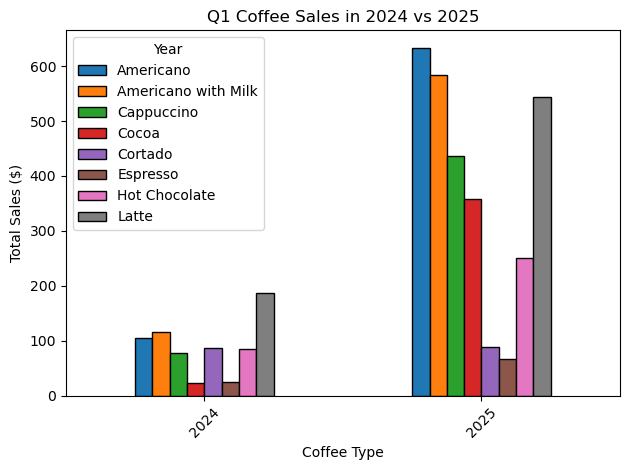

In [51]:
exec(initial_code, {"df": df})